In [1]:
from config import*
from HeatConduction import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/envs/common/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  21658


In [2]:
WPINN_model = WPINN(input_size = n_collocation, 
                    num_hidden_layers1 = 2, 
                    num_hidden_layers2 = 4, 
                    hidden_neurons = 50, 
                    family_size = len_family).to(device)

optimizer1 = optim.Adam(WPINN_model.parameters(), lr=1e-4)

In [ ]:
x_interior = x_collocation.clone()
t_interior = t_collocation.clone()
def wpinn_loss(model):   


    global c,b
    c, b = model(x_interior, t_interior)

    u = torch.mv(Wfamily, c) + b
    u_t = torch.mv(DWt, c)
    u_xx = torch.mv(DW2x, c)
    
    u_pred_ic_left = torch.mv(Wic, c) + b
    u_pred_bc_left = torch.mv(Wbc_left, c) + b
    u_pred_bc_right = torch.mv(Wbc_right, c) + b
    
    pde_loss = torch.mean((u_t - u_xx - rhs) ** 2)
    
    ic_loss = torch.mean((u_pred_ic_left - u_ic_left)** 2)

    bc_loss = torch.mean((u_pred_bc_left - u_bc_left) ** 2) + \
              torch.mean((u_pred_bc_right - u_bc_right) ** 2)
    

    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

def train_wpinn(model, optimizer, num_epochs, num_prints):

    for epoch in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        total_loss, pde_loss, ic_loss, bc_loss = wpinn_loss(model)
        
        total_loss.backward()
        optimizer.step()
    
        if epoch % ((num_epochs-1)/num_prints) == 0:  # Print every num_prints epochs
            numerical = torch.mv(Wval, c.cpu()) + b.cpu()
            errL2 = (torch.sum(torch.abs(exact_validation-numerical)**2))**0.5 / (torch.sum(torch.abs(exact_validation)**2))**0.5
            errMax = torch.max(torch.abs(exact_validation-numerical))

            print(f'Epoch [{epoch}/{num_epochs}], '
                f'Total Loss: {total_loss.item():.6f}, '
                f'PDE Loss: {pde_loss.item():.6f}, '
                f'IC Loss: {ic_loss.item():.6f}, '
                f'BC Loss: {bc_loss.item():.6f}\n\t\t'
                f'RelativeL2: {errL2},\t\t'
                f'Max: {errMax}\n' )
            
        # torch.cuda.empty_cache()
            
        

In [5]:
torch.cuda.empty_cache()

num_epochs = 2*10**4+1
num_prints = 5
train_wpinn(WPINN_model, optimizer1, num_epochs, num_prints)

  0%|          | 19/20001 [00:00<01:51, 178.60it/s]

Epoch [0/20001], Total Loss: 27687.800781, PDE Loss: 6844.965332, IC Loss: 213.377350, BC Loss: 20629.458984
		RelativeL2: 0.28183799982070923,		Max: 245.36221313476562



 20%|██        | 4024/20001 [00:29<01:54, 139.80it/s]

Epoch [4000/20001], Total Loss: 831.108704, PDE Loss: 29.458336, IC Loss: 0.026188, BC Loss: 801.624207
		RelativeL2: 0.0418570302426815,		Max: 68.85306549072266



 40%|████      | 8024/20001 [00:58<01:25, 139.99it/s]

Epoch [8000/20001], Total Loss: 52.053448, PDE Loss: 44.691250, IC Loss: 0.000456, BC Loss: 7.361739
		RelativeL2: 0.0032951077446341515,		Max: 5.8125200271606445



 60%|██████    | 12024/20001 [01:28<00:57, 139.90it/s]

Epoch [12000/20001], Total Loss: 51.530689, PDE Loss: 51.409698, IC Loss: 0.000222, BC Loss: 0.120769
		RelativeL2: 0.0003990289114881307,		Max: 0.6269683837890625



 80%|████████  | 16024/20001 [01:57<00:28, 139.82it/s]

Epoch [16000/20001], Total Loss: 10.021153, PDE Loss: 10.003725, IC Loss: 0.000188, BC Loss: 0.017241
		RelativeL2: 0.00017477344954386353,		Max: 0.1491680145263672



100%|██████████| 20001/20001 [02:27<00:00, 136.01it/s]

Epoch [20000/20001], Total Loss: 7.719370, PDE Loss: 7.706375, IC Loss: 0.000168, BC Loss: 0.012827
		RelativeL2: 0.00017038120131473988,		Max: 0.19485950469970703



In [ ]:
# Additional cofficient refinement

c_trained = c
b_trained = b

coef_refinement_model = CoefficientRefinementNetwork(initial_coefficients=c, initial_bias = b).to(device)
optimizer2 = optim.Adam(coef_refinement_model.parameters(), lr = 0.1e-2)

num_epochs = 10**4+1
num_prints = 10
train_wpinn(coef_refinement_model, optimizer2, num_epochs, num_prints)

RelativeL2: 0.0001900056522572413,		 Max: 0.828245997428894



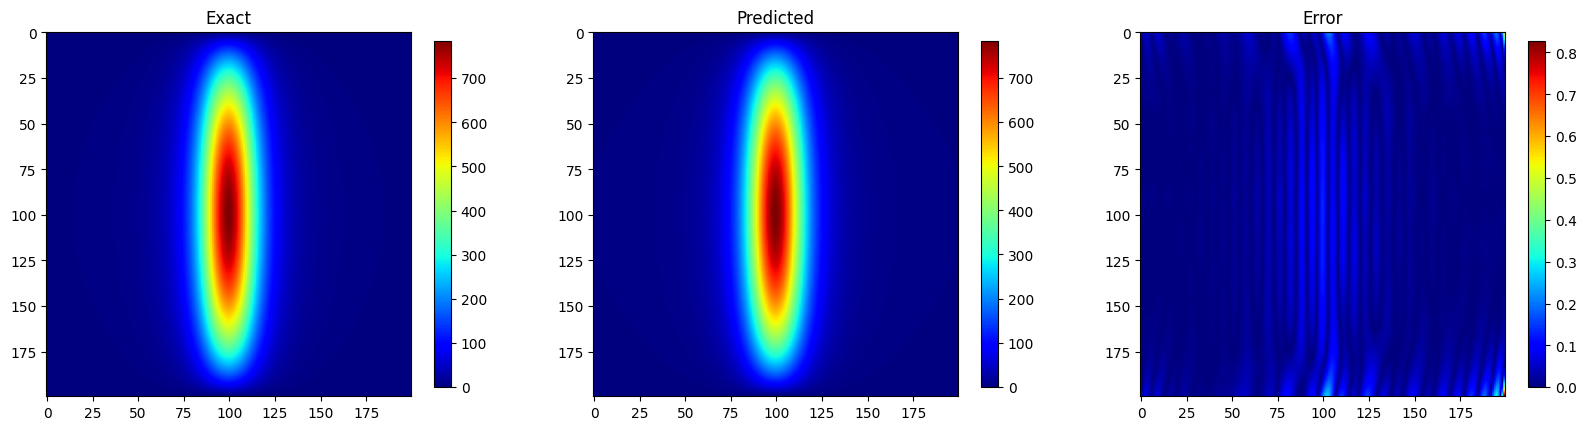

In [6]:
#  Testign and Plotting
u_pred = (torch.mv(Wtest, c.cpu()) + b.cpu()).reshape(n_test, n_test).detach().numpy()


errL2 = (np.sum(np.abs(exact_test-u_pred)**2))**0.5 / (np.sum(np.abs(exact_test)**2))**0.5
errMax = np.max(np.abs(exact_test-u_pred))


print(f'RelativeL2: {errL2},\t\t', f'Max: {errMax}\n' )

fig = plt.figure(1, figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(exact_test, cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Exact')

plt.subplot(1,3,2)
plt.imshow(u_pred, cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Predicted')

plt.subplot(1,3,3)
plt.imshow(abs(exact_test-u_pred), cmap='jet')
plt.colorbar(shrink=0.3)
plt.title('Error')

plt.savefig('sol.png')
plt.show()
